# Building up on Question 2.1 , using random forest most important features to build textual patient summaries

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from tqdm import tqdm
import itertools
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq


# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import average_precision_score, precision_recall_curve

from IPython.display import Image
import graphviz

# Scoring
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis


In [87]:

static_variables = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']

static_variables.remove('ICUType')

static_variables_we_want = ['Age', 'Gender', 'Height', 'Weight']
all_variables = ['Weight', 'Age', 'TroponinI', 'DiasABP', 'MechVent', 'HCO3', 'Cholesterol', 'HCT', 'SaO2', 'WBC', 'SysABP', 'Urine', 'ICUType', 'Gender', 'ALP', 'Creatinine', 'K', 'AST', 'Glucose', 'RespRate', 'MAP', 'FiO2', 'BUN', 'Na', 'Bilirubin', 'TroponinT', 'PaCO2', 'Height', 'GCS', 'HR', 'pH', 'PaO2', 'Lactate', 'ALT', 'NISysABP', 'RecordID', 'Platelets', 'Temp', 'Mg', 'NIDiasABP', 'Albumin', 'NIMAP']
dyn_variables = [x for x in all_variables if x not in static_variables]
dyn_variables.remove('ICUType')
dyn_variables.append('Weight_VAR')
len(dyn_variables), len(static_variables_we_want)

initial_column_lists = static_variables_we_want + dyn_variables

In [88]:

# import parquet file 
df_a =pd.read_parquet('data/processed_raw_data_set-a_1.parquet', engine='pyarrow')
df_b =pd.read_parquet('data/processed_raw_data_set-b_1.parquet', engine='pyarrow')
df_c =pd.read_parquet('data/processed_raw_data_set-c_1.parquet', engine='pyarrow')

drop_ICUType = True 
if drop_ICUType:
    df_a = df_a.drop(columns=['ICUType'])
    df_b = df_b.drop(columns=['ICUType'])
    df_c = df_c.drop(columns=['ICUType'])


#  drop Time variable in df_a
if 'Time' in df_a.columns:
    df_a = df_a.drop(columns=['Time'])
    df_b = df_b.drop(columns=['Time'])
    df_c = df_c.drop(columns=['Time'])




## Computing features vectors of our patient

Instead of working on the table where the missing values had already been filled, i prefer working on the not filled table because otherwise filled values would be taken into the mean and might flatten patient with lots of missing values. Then I compute the mean of variables for eahc patient over the 49 timestamps. 

Then i compute the median on the resulting table to fill the missing values

In [89]:
df_a

Parameter,RecordID,Age,Gender,Height,Weight,Albumin,ALP,ALT,AST,Bilirubin,...,Platelets,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight_VAR
0,132539.0,54.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,132539.0,54.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,19.0,NaN,NaN,35.35,NaN,NaN,960.0,NaN,NaN
2,132539.0,54.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN
3,132539.0,54.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,19.0,NaN,NaN,NaN,NaN,NaN,170.0,NaN,NaN
4,132539.0,54.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,NaN,NaN,37.80,NaN,NaN,60.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,142673.0,78.0,0.0,157.5,70.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,98.0,112.0,37.70,NaN,NaN,25.0,NaN,87.3
195996,142673.0,78.0,0.0,157.5,70.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,110.0,37.60,NaN,NaN,25.0,NaN,87.3
195997,142673.0,78.0,0.0,157.5,70.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,112.0,NaN,NaN,NaN,23.0,NaN,87.3
195998,142673.0,78.0,0.0,157.5,70.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,121.0,37.30,NaN,NaN,40.0,NaN,87.3


In [ ]:
# Define aggregation functions
agg_funcs = {col: ['mean','std','max','min','skew'] for col in dyn_variables}  

agg_funcs['RecordID'] = 'first'  # Keep RecordID
for stat_var in static_variables_we_want:
    if stat_var in df_a.columns:
        agg_funcs[stat_var] = 'first'  # Keep static variables

df_a_agg = df_a.groupby('RecordID').agg(agg_funcs)

df_a_agg.columns = ['_'.join(col).strip() for col in df_a_agg.columns.values]


In [ ]:
# same for df_b 
agg_funcs = {col: ['mean','std','max','min','skew'] for col in dyn_variables}
agg_funcs['RecordID'] = 'first'  # Keep RecordID
for stat_var in static_variables_we_want:
    if stat_var in df_b.columns:
        agg_funcs[stat_var] = 'first'  # Keep static variables

df_b_agg = df_b.groupby('RecordID').agg(agg_funcs)

df_b_agg.columns = ['_'.join(col).strip() for col in df_b_agg.columns.values]


In [ ]:
# same for df_c
agg_funcs = {col: ['mean','std','max','min','skew'] for col in dyn_variables}
agg_funcs['RecordID'] = 'first'  # Keep RecordID
for stat_var in static_variables_we_want:
    if stat_var in df_c.columns:
        agg_funcs[stat_var] = 'first'  # Keep static variables

df_c_agg = df_c.groupby('RecordID').agg(agg_funcs)
df_c_agg.columns = ['_'.join(col).strip() for col in df_c_agg.columns.values]

#### We do not fill nan values this time

In [96]:
df_a_agg

,TroponinI_mean,TroponinI_std,TroponinI_max,TroponinI_min,TroponinI_skew,DiasABP_mean,DiasABP_std,DiasABP_max,DiasABP_min,DiasABP_skew,...,Weight_VAR_mean,Weight_VAR_std,Weight_VAR_max,Weight_VAR_min,Weight_VAR_skew,RecordID_first,Age_first,Gender_first,Height_first,Weight_first
RecordID,,,,,,,,,,,,,,,,,,,,,
132539.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,132539.0,54.0,0.0,NaN,NaN
132540.0,NaN,NaN,NaN,NaN,NaN,58.448148,5.205690,75.0,46.0,0.285246,...,80.680000,9.820457e-01,81.6,76.0,-3.786403,132540.0,76.0,1.0,175.3,76.0
132541.0,NaN,NaN,NaN,NaN,NaN,67.666667,8.372290,81.0,52.0,-0.079364,...,56.700000,1.036433e-15,56.7,56.7,0.000000,132541.0,44.0,0.0,NaN,56.7
132543.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,84.600000,0.000000e+00,84.6,84.6,0.000000,132543.0,68.0,1.0,180.3,84.6
132545.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,132545.0,88.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142665.0,NaN,NaN,NaN,NaN,NaN,69.187943,6.671703,82.0,47.5,-0.489340,...,87.000000,NaN,87.0,87.0,NaN,142665.0,70.0,0.0,NaN,87.0
142667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,166.400000,0.000000e+00,166.4,166.4,0.000000,142667.0,25.0,1.0,NaN,166.4
142670.0,NaN,NaN,NaN,NaN,NaN,72.125000,8.759519,84.5,65.0,1.387467,...,109.000000,0.000000e+00,109.0,109.0,0.000000,142670.0,44.0,1.0,NaN,109.0


## Question 4.1 - Summary Creation 

### Extract top 100 features from Random forest model

In [97]:
# open 100_most_important_features.txt for each row extract the last text token and put in a list
with open('data/100_most_important_features.txt', 'r') as f:
    lines = f.readlines()

# Extract the last token from each line and store in a list
top_100_features  = [line.split()[-1] for line in lines]

top_100_features 

top_50_features = top_100_features[:50]
top_20_features = top_100_features[:20]

### Extract additional data from variable_data.csv

In [98]:
# open variable_data.csv : variable,description and read it as a dictionary where key is variable and value is description
variable_data = pd.read_csv('data/variable_data.csv')
variable_data = variable_data.set_index('variable').T.to_dict('list')   

variable_data




{'Albumin': ['(g/dL)'],
 'ALP': ['[Alkaline phosphatase (IU/L)]'],
 'ALT': ['[Alanine transaminase (IU/L)]'],
 'AST': ['[Aspartate transaminase (IU/L)]'],
 'Bilirubin': ['(mg/dL)'],
 'BUN': ['[Blood urea nitrogen (mg/dL)]'],
 'Cholesterol': ['(mg/dL)'],
 'Creatinine': ['[Serum creatinine (mg/dL)]'],
 'DiasABP': ['[Invasive diastolic arterial blood pressure (mmHg)]'],
 'FiO2': ['[Fractional inspired O2(0-1)]'],
 'GCS': ['[Glasgow Coma Score (3-15)]'],
 'Glucose': ['[Serum glucose (mg/dL)]'],
 'HCO3': ['[Serum bicarbonate (mmol/L)]'],
 'HCT': ['[Hematocrit (%)]'],
 'HR': ['[Heart rate (bpm)]'],
 'K': ['[Serum potassium (mEq/L)]'],
 'Lactate': ['(mmol/L)'],
 'Mg': ['[Serum magnesium (mmol/L)]'],
 'MAP': ['[Invasive mean arterial blood pressure (mmHg)]'],
 'MechVent': ['[Mechanical ventilation respiration (0:false or 1:true)]'],
 'Na': ['[Serum sodium (mEq/L)]'],
 'NIDiasABP': ['[Non-invasive diastolic arterial blood pressure (mmHg)]'],
 'NIMAP': ['[Non-invasive mean arterial blood pressur

In [99]:
# from feature and value to text token
def feature_to_text(feature):
    name_parts = feature.split('_')
    if len(name_parts) == 2:
        var, stat = name_parts
        if var in variable_data:
            return f"{stat} {var.replace('VAR', 'variance')} {variable_data[var][0]}" 
        else:
            return f"{stat} {var.replace('VAR', 'variance')}" 

    return feature

# summary text creation
def row_to_summary(row, feature_list):
    summary = []
    for feat in feature_list:
        if feat in row.index:
            val = row[feat] 
            if pd.isnull(val):
                continue
            phrase = feature_to_text(feat)
            summary.append(f"{phrase} {round(val, 2)}")
    return '. '.join(summary) + '.'

# apply to each patient
df_a_agg['summary'] = df_a_agg.apply(lambda row: row_to_summary(row, top_20_features), axis=1)

# save to csv
df_a_agg[['RecordID_first', 'summary']].to_csv('data_4/summary_text_a.csv', index=False)


In [100]:
# same for df_b_agg
df_b_agg['summary'] = df_b_agg.apply(lambda row: row_to_summary(row, top_20_features), axis=1)
df_b_agg[['RecordID_first', 'summary']].to_csv('data_4/summary_text_b.csv', index=False)

# same for df_c_agg
df_c_agg['summary'] = df_c_agg.apply(lambda row: row_to_summary(row, top_20_features), axis=1)
df_c_agg[['RecordID_first', 'summary']].to_csv('data_4/summary_text_c.csv', index=False)

In [101]:
outcomes = pd.read_csv('data/outcomes.csv')
outcomes


,RecordID,In-hospital_death
0,132539,0
1,132540,0
2,132541,0
3,132543,0
4,132545,0
...,...,...
11995,163029,0
11996,163033,0
11997,163034,0
11998,163035,0


In [102]:
summary_a = pd.read_csv('data_4/summary_text_a.csv')
summary_b = pd.read_csv('data_4/summary_text_b.csv')
summary_c = pd.read_csv('data_4/summary_text_c.csv')

#### Context for LLM

In [103]:
# print first few rows of summary_a 
for i in range(32):
    #discharged alive (1 = very unlikely, 10 = very likely).
    outcom =    outcomes[outcomes['RecordID'] == summary_a.iloc[i]['RecordID_first']]['In-hospital_death'].values[0]
    print_outcome = 10 if outcom == 0 else 1
    if i < 5:
        print(summary_a.iloc[i]['summary'] + ' ===> Outcome :' + str(print_outcome) )
    else :
        if outcom == 1:
            print(summary_a.iloc[i]['summary'] + ' ===> Outcome :' + str(print_outcome) )




mean GCS [Glasgow Coma Score (3-15)] 14.92. mean Urine [Urine output (mL)] 135.42. max GCS [Glasgow Coma Score (3-15)] 15.0. min BUN [Blood urea nitrogen (mg/dL)] 8.0. mean HCO3 [Serum bicarbonate (mmol/L)] 27.0. mean Temp [Temperature (Celsius)] 37.51. mean BUN [Blood urea nitrogen (mg/dL)] 10.5. first Age 54.0. std Platelets (cells/nL) 25.46. min WBC [White blood cell count (cells/nL)] 9.4. std Temp [Temperature (Celsius)] 0.76. skew GCS [Glasgow Coma Score (3-15)] -3.61. mean Na [Serum sodium (mEq/L)] 136.5. ===> Outcome :10
mean GCS [Glasgow Coma Score (3-15)] 13.33. mean Urine [Urine output (mL)] 126.82. max GCS [Glasgow Coma Score (3-15)] 15.0. min BUN [Blood urea nitrogen (mg/dL)] 16.0. mean HCO3 [Serum bicarbonate (mmol/L)] 22.33. mean Temp [Temperature (Celsius)] 37.14. mean BUN [Blood urea nitrogen (mg/dL)] 18.33. first Age 76.0. mean FiO2 [Fractional inspired O2(0-1)] 0.51. mean pH [Arterial pH (0-14)] 7.4. std Platelets (cells/nL) 33.31. min WBC [White blood cell count (cel

## Predictions obtained from LLM , now score : 


### Without context

In [104]:
llm_pred_for_c = pd.read_csv('data_4/predictions_4_1_for_c.csv')
# divide prediction columns by 100
llm_pred_for_c['Prediction'] = 1 - llm_pred_for_c['Prediction'] / 10
# create new column with rounded value of Prediction to the nearest integer
llm_pred_for_c['Prediction_rounded'] = llm_pred_for_c['Prediction'].round().astype(int)

#discharged alive (1 = very unlikely, 10 = very likely)
llm_pred_for_c

,RecordID,Prediction,Prediction_rounded
0,152871.0,0.6,1
1,152873.0,0.4,0
2,152875.0,0.2,0
3,152878.0,0.2,0
4,152882.0,0.3,0
...,...,...,...
3995,163029.0,0.3,0
3996,163033.0,0.2,0
3997,163034.0,0.2,0
3998,163035.0,0.2,0


In [105]:
# type of Prediction columns
llm_pred_for_c.dtypes

RecordID              float64
Prediction            float64
Prediction_rounded      int32
dtype: object

In [106]:
outcomes_c = outcomes[outcomes['RecordID'].isin(llm_pred_for_c['RecordID'])]
outcomes_c


,RecordID,In-hospital_death
8000,152871,0
8001,152873,1
8002,152875,0
8003,152878,0
8004,152882,0
...,...,...
11995,163029,0
11996,163033,0
11997,163034,0
11998,163035,0


In [107]:
roc_auc_ = roc_auc_score(outcomes_c['In-hospital_death'], llm_pred_for_c['Prediction'])

average_precision_ = average_precision_score(outcomes_c['In-hospital_death'], llm_pred_for_c['Prediction'])
print('ROC AUC Score:', roc_auc_, 'Average Precision Score:', average_precision_)

ROC AUC Score: 0.5035744766052233 Average Precision Score: 0.147189976429842


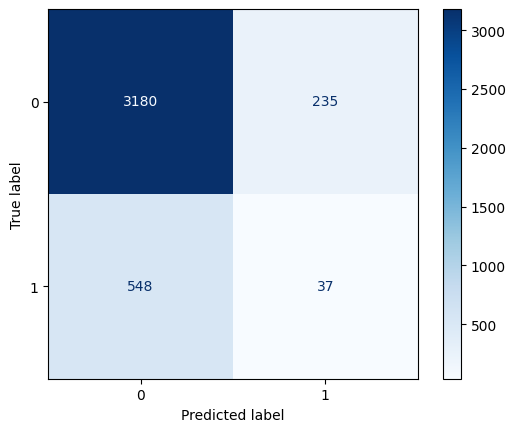

In [108]:
cm = confusion_matrix(outcomes_c['In-hospital_death'], llm_pred_for_c['Prediction_rounded'], labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)

### With context given to LLM

ROC AUC Score: 0.5304969278322135 Average Precision Score: 0.15767837271712318


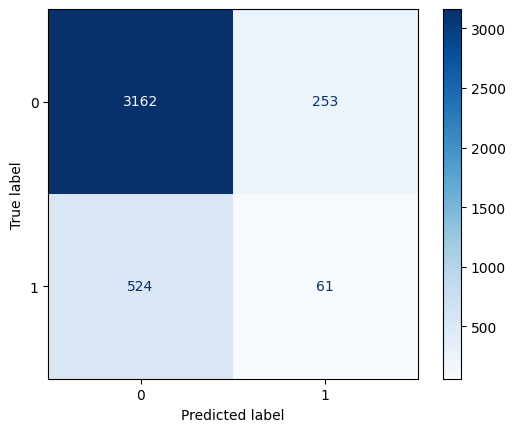

In [109]:
llm_pred_for_c_w_ctxt = pd.read_csv('data_4/predictions_4_1_for_c_w_ctxt.csv')

# divide prediction columns by 100
llm_pred_for_c_w_ctxt['Prediction'] = 1 - llm_pred_for_c_w_ctxt['Prediction'] / 10
# create new column with rounded value of Prediction to the nearest integer
llm_pred_for_c_w_ctxt['Prediction_rounded'] = llm_pred_for_c_w_ctxt['Prediction'].round().astype(int)

#discharged alive (1 = very unlikely, 10 = very likely)
llm_pred_for_c_w_ctxt
# type of Prediction columns
llm_pred_for_c_w_ctxt.dtypes
outcomes_c = outcomes[outcomes['RecordID'].isin(llm_pred_for_c_w_ctxt['RecordID'])]
outcomes_c

roc_auc_ = roc_auc_score(outcomes_c['In-hospital_death'], llm_pred_for_c_w_ctxt['Prediction'])

average_precision_ = average_precision_score(outcomes_c['In-hospital_death'], llm_pred_for_c_w_ctxt['Prediction'])
print('ROC AUC Score:', roc_auc_, 'Average Precision Score:', average_precision_)

cm = confusion_matrix(outcomes_c['In-hospital_death'], llm_pred_for_c_w_ctxt['Prediction_rounded'], labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)